In [1]:
# Load packages
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix, find
import random
import time
import pandas as pd
import pprint
from scipy.sparse import csgraph
from os.path import abspath, exists
from scipy import sparse
from sklearn.cluster import KMeans
from sklearn import preprocessing
import scipy.sparse.linalg 
import math
import scipy.io
import networkx as nx
import sklearn
import seaborn as sns
from scipy import stats
from IPython.display import Image
from scipy import ndimage
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

from sklearn.svm import OneClassSVM

from scipy.linalg.interpolative import estimate_spectral_norm\

import statistics
from scipy.stats import randint as sp_randint

from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

from numpy import arange

In [2]:
# Read in data
walmart = pd.read_csv('Data/task_4_2.csv', sep=",", header = 0)

In [3]:
# View head of data
walmart.head()

,wm_yr_wk,store_id,week_id,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,log_pct_change,...,store_id_WI_3,price_CA,price_WI,price_TX,amzn_price,gas_price,log_amzn_price,log_weekly_revenue,log_gas_price,item_on
0,11101,CA_1,1,0,0,0,0,58387.95,0.0,-1.372832,...,0,3.364,3.086,2.933,8.6492,3.364,2.157467,10.974865,1.213131,1204
1,11101,CA_2,1,0,0,0,0,46441.75,0.0,-1.372832,...,0,3.364,3.086,2.933,8.6492,3.364,2.157467,10.745954,1.213131,1035
2,11101,CA_3,1,0,0,0,0,74800.93,0.0,-1.372832,...,0,3.364,3.086,2.933,8.6492,3.364,2.157467,11.222586,1.213131,1223
3,11101,CA_4,1,0,0,0,0,27817.34,0.0,-1.372832,...,0,3.364,3.086,2.933,8.6492,3.364,2.157467,10.233415,1.213131,1053
4,11101,TX_1,1,0,0,0,0,38676.37,0.0,-1.372832,...,0,3.364,3.086,2.933,8.6492,2.933,2.157467,10.562984,1.076026,1150


<AxesSubplot:xlabel='Cultural', ylabel='weekly_revenue'>

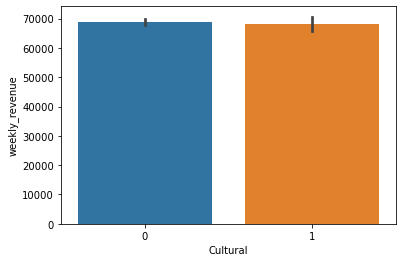

In [4]:
sns.barplot(x='Cultural', y='weekly_revenue', data=walmart)

<AxesSubplot:xlabel='Sporting', ylabel='weekly_revenue'>

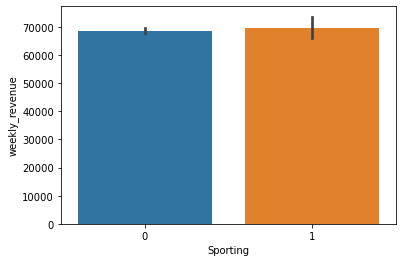

In [5]:
sns.barplot(x='Sporting', y='weekly_revenue', data=walmart)

<AxesSubplot:xlabel='National', ylabel='weekly_revenue'>

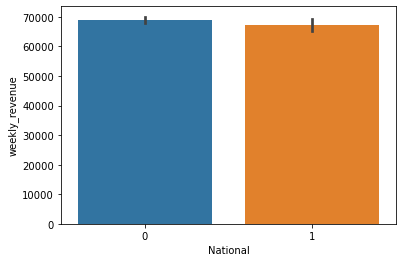

In [6]:
sns.barplot(x='National', y='weekly_revenue', data=walmart)

<AxesSubplot:xlabel='Religious', ylabel='weekly_revenue'>

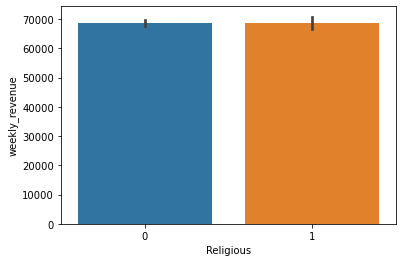

In [7]:
sns.barplot(x='Religious', y='weekly_revenue', data=walmart)

Could look at specific holidays to see if some make a difference. For instance, Christmas and Thanksgiving likely do affect revenue while Labor Day may not have an effect. However, this is not possible with weekly data.

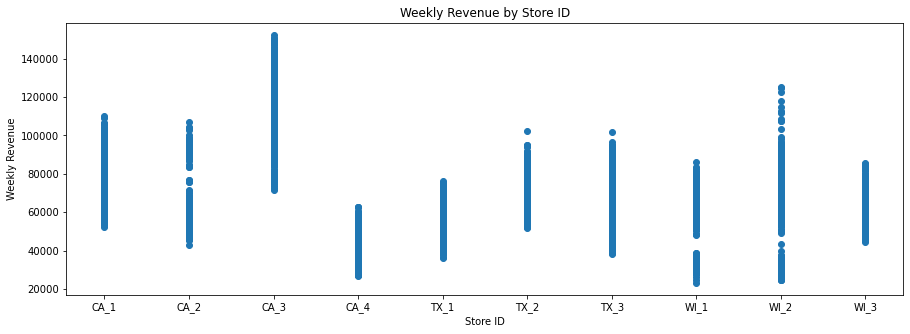

In [8]:
x = walmart['store_id']
y = walmart['weekly_revenue']
plt.figure(figsize=(15,5))
plt.title('Weekly Revenue by Store ID')
plt.xlabel('Store ID')
plt.ylabel('Weekly Revenue')
plt.scatter(x,y)
plt.show()

<AxesSubplot:xlabel='gas_price'>

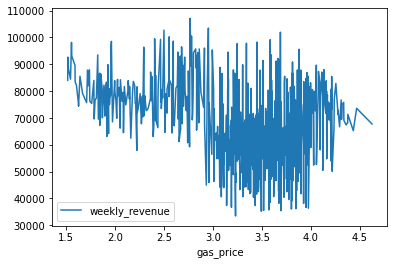

In [9]:
gas_price = pd.pivot_table(walmart, values = "weekly_revenue", index= "gas_price")
gas_price.plot()

<AxesSubplot:xlabel='amzn_price'>

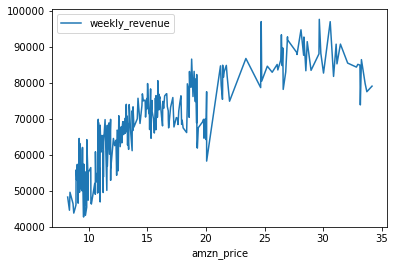

In [10]:
amzn_price = pd.pivot_table(walmart, values = "weekly_revenue", index= "amzn_price")
amzn_price.plot()

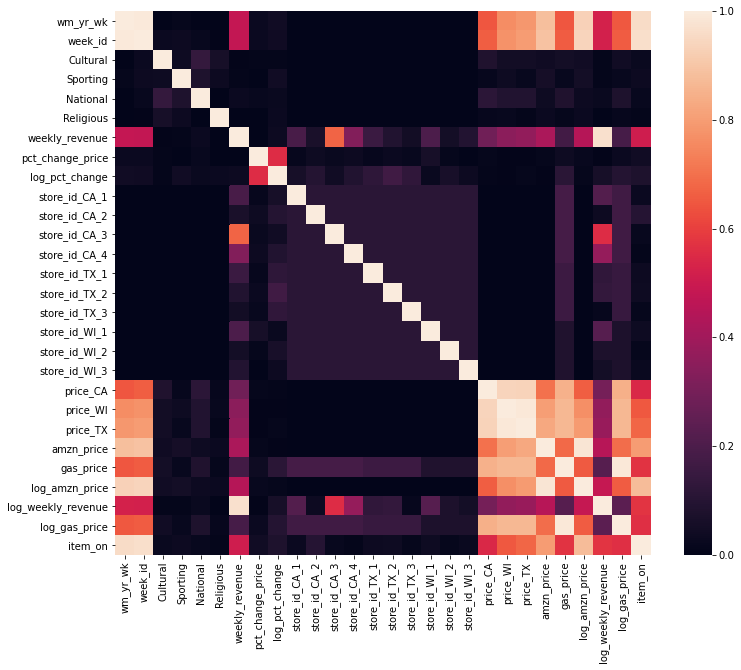

In [11]:
# Interactions between features
plt.figure(figsize = (12,10))
sns.heatmap(walmart.corr().abs())    # To see the correlations
plt.show()

In [12]:
df_new = walmart.copy()

# Subset to variables that seem appropriate - variables considered in linear regression
# Variables - week_id, store_id, log_pct_change, store_id_WI_3, price_CA, price_WI, price_TX, gas_price, log_amzn_price, log_weekly_revenue
drop_col = ['wm_yr_wk','week_id', 'store_id', 'log_pct_change', 'price_CA', 'price_WI', 'price_TX', 'log_amzn_price', 'log_weekly_revenue', 'log_gas_price']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

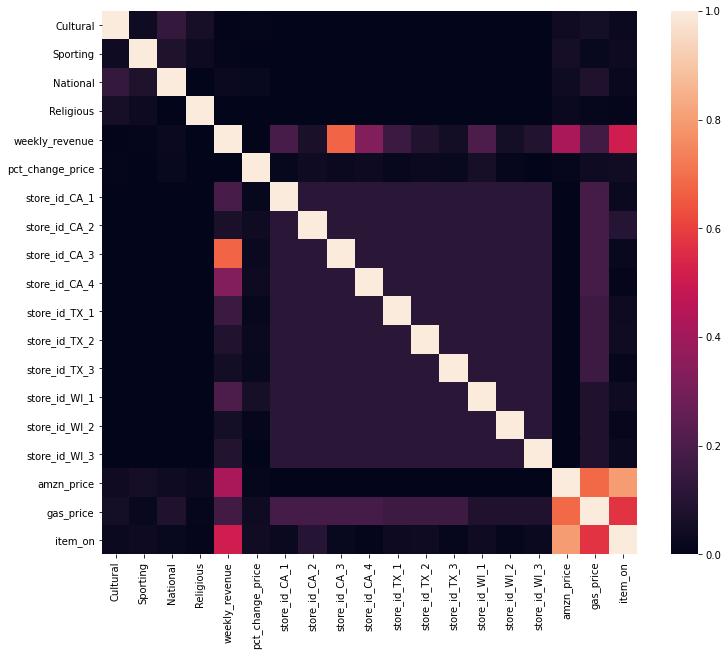

In [13]:
# Interactions between features
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

In [14]:
# Create train/test splits
X = df_new.drop('weekly_revenue', axis=1)
y = df_new['weekly_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=273)

In [15]:
X_train.head()

,Cultural,Sporting,National,Religious,pct_change_price,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,amzn_price,gas_price,item_on
1356,0,0,1,0,0.068818,0,0,0,0,0,0,1,0,0,0,14.6550,3.385000,2527
1988,0,0,0,0,0.096435,0,0,0,0,0,0,0,0,1,0,16.3769,2.856000,2967
1957,1,0,0,0,0.038188,0,0,0,0,0,0,0,1,0,0,14.8421,3.017000,2961
1497,0,0,0,0,0.004667,0,0,0,0,0,0,0,1,0,0,19.2035,3.116333,2619
1455,0,0,1,0,-0.037644,0,0,0,0,0,1,0,0,0,0,17.9670,2.959000,2612


## Random Forest

In [16]:
# Train model
RF_clf = RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1, max_depth=19,
                           max_features = 'sqrt',min_samples_split = 10)
RF_clf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=19, max_features='sqrt', min_samples_split=10,
                      n_estimators=250, n_jobs=-1, random_state=42)

In [17]:
# Generate predictions
y_pred_train_rf = RF_clf.predict(X_train)
y_pred_test_rf = RF_clf.predict(X_test)

In [18]:
# Calculate MAPE
mape_train = statistics.mean(abs((y_train - y_pred_train_rf)/y_train))

mape_test = statistics.mean(abs((y_test - y_pred_test_rf)/y_test))

print(mape_train, mape_test)

0.04467196740133749 0.06455148979424703


In [19]:
# Calculate test error by number of trees for RF
min_ = 1
max_ = 250

num_trees = []
rf_mape = []

for i in range(min_, max_ + 1):
    # Train
    RFclf_plt = RandomForestRegressor(n_estimators=i, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)
    RFclf_plt.fit(X_train, y_train.values.ravel())
    
    # Predict
    y_pred_test_rf_plt = RFclf_plt.predict(X_test)
    
    # Calculate error
    rf_mape_plt = statistics.mean(abs((y_test - y_pred_test_rf_plt)/y_test))
    num_trees.append(i)
    rf_mape.append(rf_mape_plt)

Text(0.5, 0, 'Number of Trees')

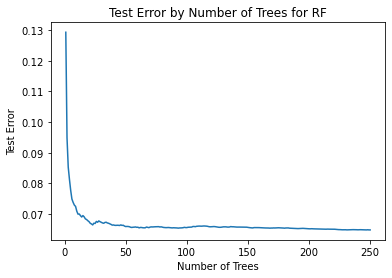

In [20]:
# Plot test error by number of trees for RF vs CART error
plt.plot(num_trees,rf_mape)
plt.title('Test Error by Number of Trees for RF')
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

In [21]:
results = list(zip(num_trees, rf_mape))

results2 = pd.DataFrame(results, columns = ['num_trees', 'rf_mape'])
results2

,num_trees,rf_mape
0,1,0.129272
1,2,0.094870
2,3,0.085303
3,4,0.081304
4,5,0.077760
...,...,...
245,246,0.064865
246,247,0.064849
247,248,0.064891
248,249,0.064847


In [22]:
min_rf_err_index = results2['rf_mape'].idxmin()
results2.iloc[min_rf_err_index,:]

num_trees    250.000000
rf_mape        0.064847
Name: 249, dtype: float64

In [23]:
# Calculate test error by number of trees for RF
min_ = 1
max_ = 50

max_depth = []
rf_mape_2 = []

for i in range(min_, max_ + 1):
    # Train
    RFclf_plt = RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1, max_depth=i,
                           max_features = 'sqrt',min_samples_split = 10)
    RFclf_plt.fit(X_train, y_train.values.ravel())
    
    # Predict
    y_pred_test_rf_plt = RFclf_plt.predict(X_test)
    
    # Calculate error
    rf_mape_plt = statistics.mean(abs((y_test - y_pred_test_rf_plt)/y_test))
    max_depth.append(i)
    rf_mape_2.append(rf_mape_plt)

Text(0.5, 0, 'Max Depth')

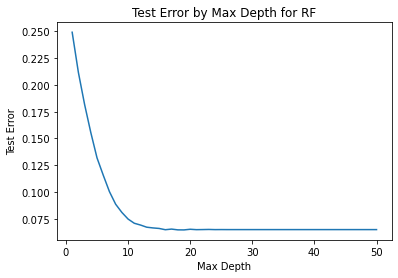

In [24]:
# Plot test error by number of trees for RF vs CART error
plt.plot(max_depth,rf_mape_2)
plt.title('Test Error by Max Depth for RF')
plt.ylabel('Test Error')
plt.xlabel('Max Depth')

In [25]:
results3 = list(zip(max_depth, rf_mape_2))

results4 = pd.DataFrame(results3, columns = ['max_depth', 'rf_mape'])
results4

,max_depth,rf_mape
0,1,0.249292
1,2,0.211796
2,3,0.181830
3,4,0.155570
4,5,0.131889
5,6,0.115758
6,7,0.100339
7,8,0.088570
8,9,0.080908
9,10,0.074706


In [26]:
min_rf_err_index_2 = results4['rf_mape'].idxmin()
results4.iloc[min_rf_err_index_2,:]

max_depth    19.000000
rf_mape       0.064551
Name: 18, dtype: float64

Feature ranking:
1. feature 7 (0.393595)
2. feature 17 (0.198681)
3. feature 15 (0.095214)
4. feature 8 (0.074699)
5. feature 16 (0.064957)
6. feature 5 (0.039415)
7. feature 12 (0.021637)
8. feature 9 (0.019608)
9. feature 4 (0.018636)
10. feature 14 (0.018364)
11. feature 10 (0.016444)
12. feature 13 (0.014186)
13. feature 6 (0.012349)
14. feature 11 (0.005542)
15. feature 2 (0.002300)
16. feature 3 (0.001570)
17. feature 1 (0.001426)
18. feature 0 (0.001377)


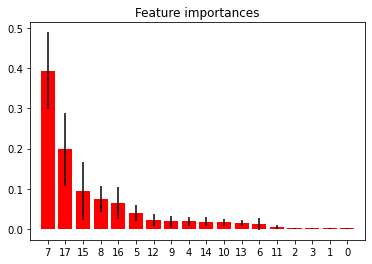

In [27]:
importances = RF_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [28]:
# Variables - week_id, store_id, log_pct_change, store_id_WI_3, price_CA, price_WI, price_TX, gas_price, log_amzn_price, log_weekly_revenue,

## Lasso Regularization (L1)

In [29]:
#define cross-validation method to evaluate model and determine optimal lambda (called alpha in Python)
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

#define model
model = LassoCV(alphas=arange(0.01, 1, 0.01), cv=cv, n_jobs=-1)

#fit model
model.fit(X_train, y_train)

#display lambda that produced the lowest test MSE
print(model.alpha_)

0.99


In [30]:
y_pred_train_l1 = model.predict(X_train)
y_pred_test_l1 = model.predict(X_test)

In [31]:
# Calculate MAPE
mape_train = statistics.mean(abs((y_train - y_pred_train_l1)/y_train))

mape_test = statistics.mean(abs((y_test - y_pred_test_l1)/y_test))

print(mape_train, mape_test)

0.10962469041347854 0.11227507421244685


In [32]:
print(np.sum(model.coef_ != 0))

names = X_train.columns

print([(names[i], model.coef_[i]) for i in range(len(names))])

17
[('Cultural', 338.66659102310075), ('Sporting', 2590.1850806416223), ('National', -2117.343716662483), ('Religious', 125.67853220414295), ('pct_change_price', -196.7800101619293), ('store_id_CA_1', 17226.50009330765), ('store_id_CA_2', 1673.6012125375541), ('store_id_CA_3', 52703.385230239255), ('store_id_CA_4', -19145.433615359732), ('store_id_TX_1', -8016.920115690432), ('store_id_TX_2', 9782.710131140115), ('store_id_TX_3', -0.0), ('store_id_WI_1', -9511.512788447908), ('store_id_WI_2', 619.2051081173969), ('store_id_WI_3', -3355.7626241008684), ('amzn_price', 319.0389528708513), ('gas_price', -466.7858038689861), ('item_on', 17.479321189781377)]


## Evaluate RF Model on testing dataset

In [33]:
# Read in evaluation data
eval_df = pd.read_csv('Data/task_5.csv', sep=",", header = 0)

eval_df.head()

,wm_yr_wk,store_id,week_id,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,log_pct_change,...,store_id_WI_3,price_CA,price_WI,price_TX,amzn_price,gas_price,log_amzn_price,log_weekly_revenue,log_gas_price,item_on
0,11614,CA_1,275,1,0,0,1,111473.48,-0.023101,-1.468426,...,0,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.621542,1.022331,3049
1,11614,CA_2,275,1,0,0,1,110671.45,0.053453,-1.181424,...,0,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.614321,1.022331,3049
2,11614,CA_3,275,1,0,0,1,153107.45,0.097569,-1.047090,...,0,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.938895,1.022331,3049
3,11614,CA_4,275,1,0,0,1,65648.12,-0.001763,-1.379815,...,0,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.092064,1.022331,3049
4,11614,TX_1,275,1,0,0,1,75887.06,0.051465,-1.187924,...,0,2.779667,2.124,1.937333,33.591099,1.937333,3.514261,11.237001,0.661312,3049


In [34]:
eval_new = eval_df.copy()

# Subset to variables that seem appropriate - variables considered in linear regression
# Variables - week_id, store_id, log_pct_change, store_id_WI_3, price_CA, price_WI, price_TX, gas_price, log_amzn_price, log_weekly_revenue
drop_col = ['wm_yr_wk','week_id', 'store_id', 'log_pct_change', 'price_CA', 'price_WI', 'price_TX', 'log_amzn_price', 'log_weekly_revenue', 'log_gas_price']
eval_new.drop(drop_col, axis=1, inplace=True) # dropping columns

eval_new.head()

,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,amzn_price,gas_price,item_on
0,1,0,0,1,111473.48,-0.023101,1,0,0,0,0,0,0,0,0,0,33.591099,2.779667,3049
1,1,0,0,1,110671.45,0.053453,0,1,0,0,0,0,0,0,0,0,33.591099,2.779667,3049
2,1,0,0,1,153107.45,0.097569,0,0,1,0,0,0,0,0,0,0,33.591099,2.779667,3049
3,1,0,0,1,65648.12,-0.001763,0,0,0,1,0,0,0,0,0,0,33.591099,2.779667,3049
4,1,0,0,1,75887.06,0.051465,0,0,0,0,1,0,0,0,0,0,33.591099,1.937333,3049


In [35]:
X_eval = eval_new.drop('weekly_revenue', axis = 1)
y_eval = eval_new['weekly_revenue']

In [36]:
# Generate predictions
y_pred_eval_rf = RF_clf.predict(X_eval)

In [37]:
# Calculate MAPE
mape_eval_rf = statistics.mean(abs((y_eval - y_pred_eval_rf)/y_eval))

print(mape_eval_rf)

0.49354800539521276


In [38]:
# Merge prediction to dataset to sort by week
df_eval_rf = pd.DataFrame({'y_pred_eval_rf':y_pred_eval_rf})

df_eval_rf_2= pd.concat([eval_df, df_eval_rf], axis=1)

df_eval_rf_2.head()

,wm_yr_wk,store_id,week_id,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,log_pct_change,...,price_CA,price_WI,price_TX,amzn_price,gas_price,log_amzn_price,log_weekly_revenue,log_gas_price,item_on,y_pred_eval_rf
0,11614,CA_1,275,1,0,0,1,111473.48,-0.023101,-1.468426,...,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.621542,1.022331,3049,96115.663523
1,11614,CA_2,275,1,0,0,1,110671.45,0.053453,-1.181424,...,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.614321,1.022331,3049,91001.128660
2,11614,CA_3,275,1,0,0,1,153107.45,0.097569,-1.047090,...,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.938895,1.022331,3049,131973.357272
3,11614,CA_4,275,1,0,0,1,65648.12,-0.001763,-1.379815,...,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.092064,1.022331,3049,57893.695929
4,11614,TX_1,275,1,0,0,1,75887.06,0.051465,-1.187924,...,2.779667,2.124,1.937333,33.591099,1.937333,3.514261,11.237001,0.661312,3049,69349.365275


In [39]:
df_eval_rf_2['error'] = abs((df_eval_rf_2['weekly_revenue'] - df_eval_rf_2['y_pred_eval_rf'])/df_eval_rf_2['weekly_revenue'])

In [40]:
df_eval_rf_2.groupby('week_id').agg('mean')

,wm_yr_wk,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,log_pct_change,store_id_CA_1,store_id_CA_2,...,price_WI,price_TX,amzn_price,gas_price,log_amzn_price,log_weekly_revenue,log_gas_price,item_on,y_pred_eval_rf,error
week_id,,,,,,,,,,,,,,,,,,,,,
275,11614.0,1.0,0.0,0.0,1.0,99577.238,0.041642,-1.245838,0.1,0.1,...,2.124,1.937333,33.591099,2.330267,3.514261,11.482404,0.833316,3049.0,86363.548612,0.129320
276,11615.0,1.0,0.0,0.0,0.0,98888.575,0.087889,-1.108856,0.1,0.1,...,2.151,1.959667,35.238999,2.346933,3.562153,11.476141,0.841216,3049.0,85757.919394,0.130504
277,11616.0,0.0,0.0,0.0,0.0,98874.169,0.035387,-1.274810,0.1,0.1,...,2.178,1.982000,35.047000,2.363600,3.556690,11.478937,0.849027,3049.0,86156.286880,0.130526
278,11617.0,0.0,0.0,0.0,0.0,33769.307,0.010034,-1.348631,0.1,0.1,...,2.280,2.072000,35.364500,2.427200,3.565708,10.395385,0.878226,3049.0,86217.063955,1.583843


## Evaluate L1 model on testing dataset

In [41]:
y_pred_eval_l1 = model.predict(X_eval)

In [42]:
# Calculate MAPE
mape_eval_l1 = statistics.mean(abs((y_eval - y_pred_eval_l1)/y_eval))
print(mape_eval_l1)

0.4921553311577838


In [43]:
# Merge prediction to dataset to sort by week
df_eval_l1 = pd.DataFrame({'y_pred_eval_l1':y_pred_eval_l1})

df_eval_l1_2= pd.concat([eval_df, df_eval_l1], axis=1)

df_eval_l1_2.head()

,wm_yr_wk,store_id,week_id,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,log_pct_change,...,price_CA,price_WI,price_TX,amzn_price,gas_price,log_amzn_price,log_weekly_revenue,log_gas_price,item_on,y_pred_eval_l1
0,11614,CA_1,275,1,0,0,1,111473.48,-0.023101,-1.468426,...,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.621542,1.022331,3049,99498.024636
1,11614,CA_2,275,1,0,0,1,110671.45,0.053453,-1.181424,...,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.614321,1.022331,3049,83930.061527
2,11614,CA_3,275,1,0,0,1,153107.45,0.097569,-1.047090,...,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.938895,1.022331,3049,134951.164343
3,11614,CA_4,275,1,0,0,1,65648.12,-0.001763,-1.379815,...,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.092064,1.022331,3049,63121.892155
4,11614,TX_1,275,1,0,0,1,75887.06,0.051465,-1.187924,...,2.779667,2.124,1.937333,33.591099,1.937333,3.514261,11.237001,0.661312,3049,74633.120619


In [44]:
df_eval_l1_2['error'] = abs((df_eval_l1_2['weekly_revenue'] - df_eval_l1_2['y_pred_eval_l1'])/df_eval_l1_2['weekly_revenue'])

In [45]:
df_eval_l1_2.groupby('week_id').agg('mean')

,wm_yr_wk,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,log_pct_change,store_id_CA_1,store_id_CA_2,...,price_WI,price_TX,amzn_price,gas_price,log_amzn_price,log_weekly_revenue,log_gas_price,item_on,y_pred_eval_l1,error
week_id,,,,,,,,,,,,,,,,,,,,,
275,11614.0,1.0,0.0,0.0,1.0,99577.238,0.041642,-1.245838,0.1,0.1,...,2.124,1.937333,33.591099,2.330267,3.514261,11.482404,0.833316,3049.0,86666.135304,0.120040
276,11615.0,1.0,0.0,0.0,0.0,98888.575,0.087889,-1.108856,0.1,0.1,...,2.151,1.959667,35.238999,2.346933,3.562153,11.476141,0.841216,3049.0,87049.320647,0.109839
277,11616.0,0.0,0.0,0.0,0.0,98874.169,0.035387,-1.274810,0.1,0.1,...,2.178,1.982000,35.047000,2.363600,3.556690,11.478937,0.849027,3049.0,86651.950452,0.117523
278,11617.0,0.0,0.0,0.0,0.0,33769.307,0.010034,-1.348631,0.1,0.1,...,2.280,2.072000,35.364500,2.427200,3.565708,10.395385,0.878226,3049.0,86728.546786,1.621219


## CUSUM

In [53]:
import numpy as np
from pyanom.outlier_detection import CAD

model = CAD(threshold=1.0)
model.fit(y)
anomaly_score = model.score(y_eval)

anomaly_score

array([[0.9933493 ],
       [1.89194864],
       [7.80383871],
       [3.38348615],
       [0.17273824],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.34101315],
       [0.        ],
       [0.53650025],
       [0.96206213],
       [6.3638703 ],
       [1.77106153],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [2.06103988],
       [0.        ],
       [0.80847446],
       [1.94593875],
       [6.89989405],
       [2.43830789],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.11210603],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])